# Laboratorio 7 - Cart Pole - REINFORCE
Francisco Castillo - 21526
Diego Lemus - 

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import random
import os

Seeds para reproducibilidad

In [2]:
SEED = 21562
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
env = gym.make('CartPole-v1')
env.action_space.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
model_file = 'model/cartpole_policy_net.pth'
episode_total_rewards_file = 'data/episode_total_rewards.npy'
rolling_avg_rewards_file = 'data/rolling_avg_rewards.npy'
plot_file = 'data/training_progress_plot.png'

## REINFORCE

### Policy Network

In [4]:
class PolicyNetwork(nn.Module):
    def __init__(self, observation_space_size, action_space_size):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(observation_space_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, action_space_size)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.softmax(self.fc3(x), dim=-1)

### Value Function

In [5]:
class ValueEstimator(nn.Module):
    def __init__(self, observation_space_size):
        super(ValueEstimator, self).__init__()
        self.fc1 = nn.Linear(observation_space_size, 128) # Added layer
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

### Environment

In [6]:
observation_space_size = env.observation_space.shape[0]
action_space_size = env.action_space.n

print(f"Observation space size: {observation_space_size}")
print(f"Action space size: {action_space_size}")

Observation space size: 4
Action space size: 2


### Hyperparameters

In [7]:
hyperparameters = {'learning_rate_policy': 0.001, 'learning_rate_value': 0.05, 'gamma': 0.99}
window_size = 100 # Define the window size for the rolling average
num_episodes_final_train = 1000

### Model

In [8]:
policy_net = PolicyNetwork(observation_space_size, action_space_size)
value_estimator = ValueEstimator(observation_space_size)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=hyperparameters['learning_rate_policy'])
value_optimizer = optim.Adam(value_estimator.parameters(), lr=hyperparameters['learning_rate_value'])
gamma = hyperparameters['gamma']

Episode 25, Total Reward: 30.0, Rolling Avg Reward (100 episodes): 27.08
Episode 50, Total Reward: 73.0, Rolling Avg Reward (100 episodes): 35.00
Episode 75, Total Reward: 44.0, Rolling Avg Reward (100 episodes): 52.27
Episode 100, Total Reward: 202.0, Rolling Avg Reward (100 episodes): 84.64
Episode 125, Total Reward: 574.0, Rolling Avg Reward (100 episodes): 149.94
Episode 150, Total Reward: 328.0, Rolling Avg Reward (100 episodes): 255.92
Episode 175, Total Reward: 463.0, Rolling Avg Reward (100 episodes): 358.28
Episode 200, Total Reward: 3001.0, Rolling Avg Reward (100 episodes): 517.25
Episode 225, Total Reward: 2005.0, Rolling Avg Reward (100 episodes): 859.33
Episode 250, Total Reward: 3001.0, Rolling Avg Reward (100 episodes): 1334.31
Episode 275, Total Reward: 3001.0, Rolling Avg Reward (100 episodes): 1926.94
Episode 300, Total Reward: 3001.0, Rolling Avg Reward (100 episodes): 2398.88
Episode 325, Total Reward: 3001.0, Rolling Avg Reward (100 episodes): 2657.71
Episode 350,

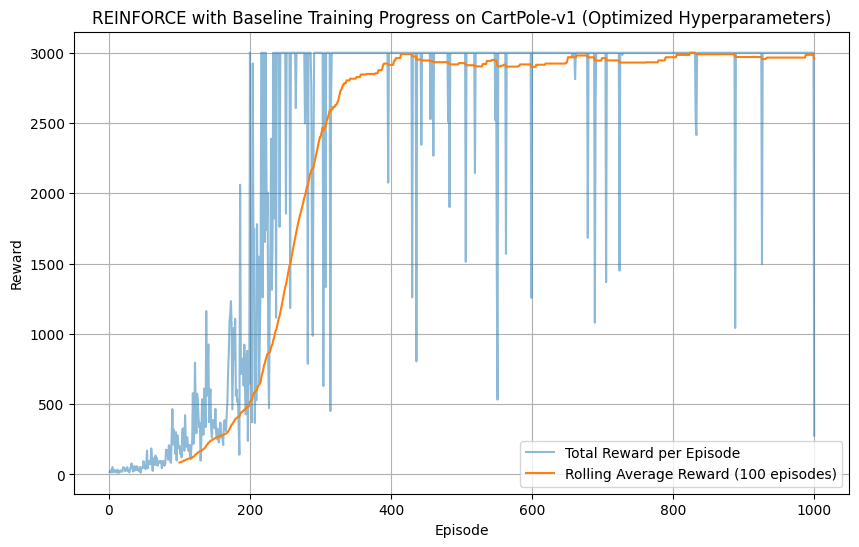

Performance data saved to 'data/episode_total_rewards.npy' and 'data/rolling_avg_rewards.npy'
Training progress plot saved to 'data/training_progress_plot.png'
Policy network saved to model/cartpole_policy_net.pth


<Figure size 640x480 with 0 Axes>

In [9]:
if os.path.exists(model_file):
    print(f"Loading saved model from {model_file}")
    policy_net.load_state_dict(torch.load(model_file))

    if os.path.exists(episode_total_rewards_file) and os.path.exists(rolling_avg_rewards_file):
        print("Loading and plotting performance data...")
        episode_total_rewards = np.load(episode_total_rewards_file).tolist()
        rolling_avg_rewards = np.load(rolling_avg_rewards_file).tolist()

        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(episode_total_rewards) + 1),
                 episode_total_rewards,
                 label='Total Reward per Episode',
                 alpha=0.5)
        plt.plot(range(window_size, len(rolling_avg_rewards) + window_size),
                 rolling_avg_rewards[window_size - 1:],
                 label=f'Rolling Average Reward ({window_size} episodes)')
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.title("REINFORCE with Baseline Training Progress on CartPole-v1")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No saved performance data found.")

else:
    episode_total_rewards = []
    rolling_avg_rewards = []
    max_episode_steps = 3_000

    # Start the main training loop
    for episode in range(num_episodes_final_train):
        state, _ = env.reset()
        episode_states = []
        episode_actions = []
        episode_rewards = []
        episode_log_probs = []
        done = False
        steps_in_episode = 0

        while not done and steps_in_episode <= max_episode_steps:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action_probs = policy_net(state_tensor)
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action)
            next_state, reward, done, _, _ = env.step(action.item())

            # Store data for the current episode
            episode_states.append(state)
            episode_actions.append(action)
            episode_rewards.append(reward)
            episode_log_probs.append(log_prob)

            state = next_state
            steps_in_episode += 1

        total_reward = sum(episode_rewards)
        episode_total_rewards.append(total_reward)

        # Calculate discounted returns
        discounted_returns = []
        R = 0
        for reward in reversed(episode_rewards):
            R = reward + gamma * R
            discounted_returns.insert(0, R)

        # Convert to tensors
        episode_states_tensor = torch.FloatTensor(np.array(episode_states))
        episode_log_probs_tensor = torch.cat(episode_log_probs)
        discounted_returns_tensor = torch.FloatTensor(discounted_returns)

        # Advantage
        predicted_values = value_estimator(episode_states_tensor).squeeze()
        advantage = discounted_returns_tensor - predicted_values

        # Policy loss
        policy_loss = -(advantage.detach() * episode_log_probs_tensor).mean()

        # Value loss
        value_loss = F.mse_loss(predicted_values, discounted_returns_tensor)

        # Update networks
        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

        # Rolling average
        if len(episode_total_rewards) >= window_size:
            rolling_avg = np.mean(episode_total_rewards[-window_size:])
            rolling_avg_rewards.append(rolling_avg)
        else:
            rolling_avg_rewards.append(np.mean(episode_total_rewards))

        if (episode + 1) % 25 == 0:
            print(f"Episode {episode + 1}, Total Reward: {total_reward}, "
                  f"Rolling Avg Reward ({window_size} episodes): {rolling_avg_rewards[-1]:.2f}")

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_episodes_final_train + 1),
             episode_total_rewards,
             label='Total Reward per Episode',
             alpha=0.5)
    plt.plot(range(window_size, num_episodes_final_train + 1),
             rolling_avg_rewards[window_size - 1:],
             label=f'Rolling Average Reward ({window_size} episodes)')
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("REINFORCE with Baseline Training Progress on CartPole-v1 (Optimized Hyperparameters)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Save results
    np.save(episode_total_rewards_file, np.array(episode_total_rewards))
    np.save(rolling_avg_rewards_file, np.array(rolling_avg_rewards))
    print(f"Performance data saved to '{episode_total_rewards_file}' and '{rolling_avg_rewards_file}'")

    plt.savefig(plot_file)
    print(f"Training progress plot saved to '{plot_file}'")

    torch.save(policy_net.state_dict(), model_file)
    print(f"Policy network saved to {model_file}")

env.close()

In [10]:
# env_render = gym.make('CartPole-v1', render_mode='human')
# state, _ = env_render.reset()
# done = False
# while not done:
#     state_tensor = torch.FloatTensor(state).unsqueeze(0)
#     action_probs = policy_net(state_tensor)
#     action_dist = torch.distributions.Categorical(action_probs)
#     action = action_dist.sample()
#     next_state, reward, done, _, _ = env_render.step(action.item())
#     state = next_state

# env_render.close()